In [1]:
import sys
import os
import json
import regex as re
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').cuda()


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/wangqianle/miniconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/wangqianle/miniconda3/envs/llm/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/wangqianle/miniconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


In [2]:
mbpp_train10 = [
    "Write a function to extract a specified column from a given nested list.",
    "Write a function to remove particular data type elements from the given tuple.",
    "Write a function to get the sum of a non-negative integer.",
    "Write a python function to find the surface area of the square pyramid.",
    "Write a python function to find minimum sum of factors of a given number.",
    "Write a python function to find the first repeated word in a given string.",
    "Write a python function to find the maximum element in a sorted and rotated array.",
    "Write a python function to check whether an array is subarray of another or not.",
    "Write a function to print check if the triangle is scalene or not.",
    "Write a python function to find the difference between sum of cubes of first n natural numbers and the sum of first n natural numbers."
]
for i in range(len(mbpp_train10)):
    mbpp_train10[i] = re.split('^Write[^,.]+to', mbpp_train10[i])[1].strip()

In [3]:
def random_instructions(filename, size):
    with open(filename) as f:
        if filename.endswith('jsonl'):
            data = []
            for line in f:
                data.append(json.loads(line.strip()))
        else:
            data = json.load(f)
    
    np.random.seed(42)
    samples = np.random.choice(data, size=size, replace=False)
    instructions = []
    for sample in samples:
        stemming = True
        if 'synthesized' in filename:
            instruction = sample['original_instruction']
        elif 'sharegpt' in filename.lower():
            instruction = sample['items'][0]['value']
            stemming = False
        else:
            instruction = sample['text']
        
        instruction_split = re.split('^Write[^,.]+to', instruction)
        if stemming and len(instruction_split) > 1:
            instruction = instruction_split[1].strip()
        
        instructions.append(instruction)
        
    return instructions

In [4]:
def mean_pooling(model_output, attention_mask):
    # First element of model_output contains all token embeddings
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, dim=1) / torch.clamp(torch.sum(input_mask_expanded, dim=1), min=1e-9)

@torch.no_grad()
def get_text_representation(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to('cuda')
    with torch.no_grad():
        output = model(**inputs)
    text_embeddings = mean_pooling(output, inputs['attention_mask'])
    
    # Normalize embeddings
    text_embeddings = F.normalize(text_embeddings, p=2, dim=1)
    return text_embeddings.cpu().numpy()

In [5]:
def random_instruction_representation(filename, size=100):
    instructions = random_instructions(filename, size=size)
    instruction_representations = get_text_representation(instructions)
    return instruction_representations

In [6]:
real_reps = random_instruction_representation('../diversity_analysis/mbpp.jsonl')
syn_reps = random_instruction_representation('../../data/ada-instruct/mbpp_synthesized_10k.jsonl')
share_reps = random_instruction_representation('sharegpt-code-en-python-sample100.json')
train_reps = get_text_representation(mbpp_train10)

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15).fit_transform(np.concatenate([share_reps, syn_reps, real_reps, train_reps], axis=0))
share_tsne, syn_tsne, real_tsne, train_tsne = tsne[:100], tsne[100: 200], tsne[200: 300], tsne[300:]

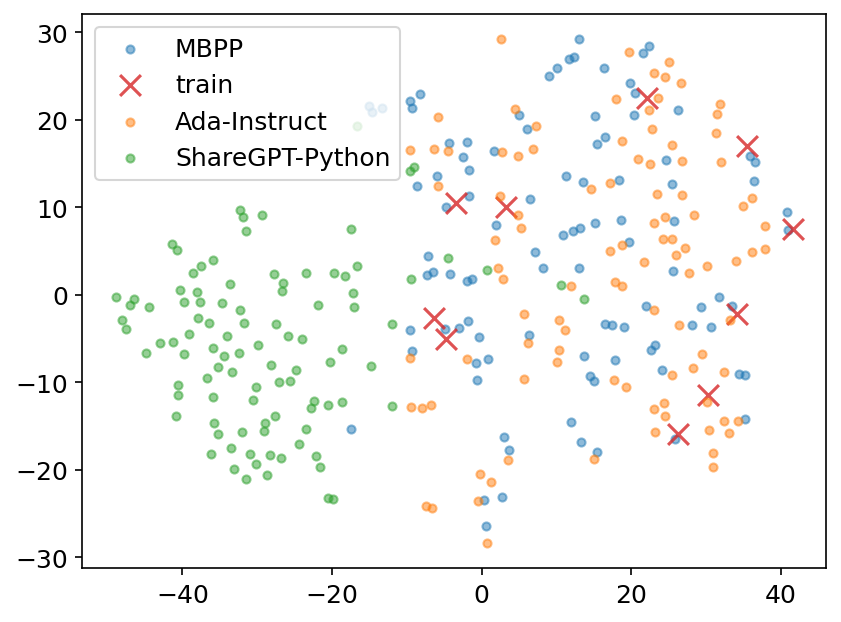

In [8]:
fig = plt.figure(dpi=150)
plt.scatter(real_tsne[:, 0], real_tsne[:, 1], label='MBPP', alpha=0.5, s=15)
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], label='train', alpha=0.8, s=100, marker='x', c='#d62728')
plt.scatter(syn_tsne[:, 0], syn_tsne[:, 1], label='Ada-Instruct', alpha=0.5, s=15)
plt.scatter(share_tsne[:, 0], share_tsne[:, 1], label='ShareGPT-Python', alpha=0.5, s=15)
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', prop={'size': 12})
plt.show()